In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import itertools
from matplotlib.collections import PathCollection
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csgraph
import umap
from sklearn import linear_model
from collections import Counter
import sklearn
import scipy.stats as sps
from scipy.spatial.distance import cdist
from importlib import reload
import sys
import gget

# locals
sys.path.append("../")
import utils as ut
reload(ut)

2023-06-20 14:07:12.024259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 14:07:20.046979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-20 14:07:20.047017: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-20 14:07:20.722091: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-20 14:07:30.764259: W tensorflow/stream_executor/pla

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/clustering/../utils.py'>

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = lf.drop_duplicates(subset='cellId')
    lf = lf[lf['cellType'].isin(macTypes)]
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    

    cellIds = lf['cellId'].to_list()
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']

    rf = rf[rf.index.isin(cellIds)]
    print(f"{key=} {lf.shape=} {rf.shape}")
    
    rf = ut.normalize(rf, 1e6)
    rna[key] = rf
    

print('done')


ND...
key='ND' lf.shape=(360, 6) (359, 31053)
HFD8...
key='HFD8' lf.shape=(2194, 6) (2188, 31053)
HFD14...
key='HFD14' lf.shape=(3893, 6) (3884, 31053)
done


In [3]:
genes = [
    'Mrc1',
    'lyve1',
    # 'tnf',
    'Trem2',
    # 'Timd4',
    'Lgals3',
    'Itgax',
    # 'Cd9',
    'cd68',
    # 'pparg',
    # 'gpnmb',
    # 'lrp1',
    # 'apoe',
    # 'app',
    # 'H2-AA',
    'H2-EB1',
    'Fcgr1',
    # 'C3',
]


macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

genes = [x.upper() for x in genes]
[print(x) for x in genes if not x in rna['ND'].columns]


res = []

for key in keys:
    lf = labels[key]
    rf = rna[key][genes]

    for mt in macTypes:
        cids = lf[lf['cellType'] == mt]['cellId'].to_list()
        pdf = rf[rf.index.isin(cids)]
        pdf = pdf.reset_index(drop=False)
        pdf = pd.melt(pdf, id_vars='cellId')
        pdf.columns = ['cellId', 'gene', 'cpm']
        pdf['cellType'] = mt
        pdf['key'] = key
    
        res.append(pdf)

res = pd.concat(res)
print(f"{res.shape=}")
res.head()


res.shape=(51448, 5)


,cellId,gene,cpm,cellType,key
0,AAAGAACGTCTACAGT.1,MRC1,4390.779363,Mac1,ND
1,AAAGAACTCCTCGCAT.1,MRC1,1765.614655,Mac1,ND
2,AACAAAGGTTCACGAT.1,MRC1,497.429945,Mac1,ND
3,AACAGGGAGCTGAAGC.1,MRC1,3517.720517,Mac1,ND
4,AAGAACAAGACTCATC.1,MRC1,894.454383,Mac1,ND


In [4]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 8, 1.5

# keyMap = {
#     'ND' : 'ND',
#     'HFD8' : '8w',
#     'HFD14' : '14w',
# }


# fig, axs = plt.subplots(1, 3, sharey=True)
# axs = axs.ravel()

# for i,key in enumerate(keys):
#     tdf = res[res['key'] == key]
    
#     tdf = pd.pivot_table(tdf, 
#                          index='cellType', 
#                          columns='gene',
#                          values='cpm')
#     tdf = tdf.astype(float)
#     tdf = np.log1p(tdf)
#     tdf.columns = [x.lower().capitalize() for x in tdf.columns]
    
#     sns.heatmap(data=tdf,
#                 ax=axs[i],
#                 cbar=False,
#                 # annot=True,
#                 cmap='PuOr')

#     axs[i].set_ylabel("")
#     axs[i].set_title(keyMap[key])

#     # break

In [5]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 6, 1.5

# keyMap = {
#     'ND' : 'ND',
#     'HFD8' : '8w',
#     'HFD14' : '14w',
# }


# fig, axs = plt.subplots(1, 3, sharey=True)
# axs = axs.ravel()

# for i,key in enumerate(keys):
#     tdf = res[res['key'] == key].reset_index(drop=True)
#     tdf['cpm'] = tdf['cpm'].astype(float)
#     tdf['cpm'] = np.log1p(tdf['cpm'])
#     tdf['gene'] = tdf['gene'].apply(lambda x: x.lower().capitalize())

#     tdf = tdf.groupby(['gene', 'cellType', 'key'])['cpm'].mean().reset_index(drop=False)

#     sns.scatterplot(data=tdf, 
#                     x='gene',
#                     y='cellType',
#                     size='cpm',
#                     hue='cpm',
#                     ec='k',
#                     palette='coolwarm_r',
#                     legend=False,
#                     ax=axs[i])

#     axs[i].tick_params(axis='x', rotation=90)
#     axs[i].set_ylim([5, -1])
#     axs[i].set_xlim([-1, len(genes)+1])
#     axs[i].set_xlabel("")
#     axs[i].set_ylabel("")
#     axs[i].set_title(keyMap[key])
#     # break


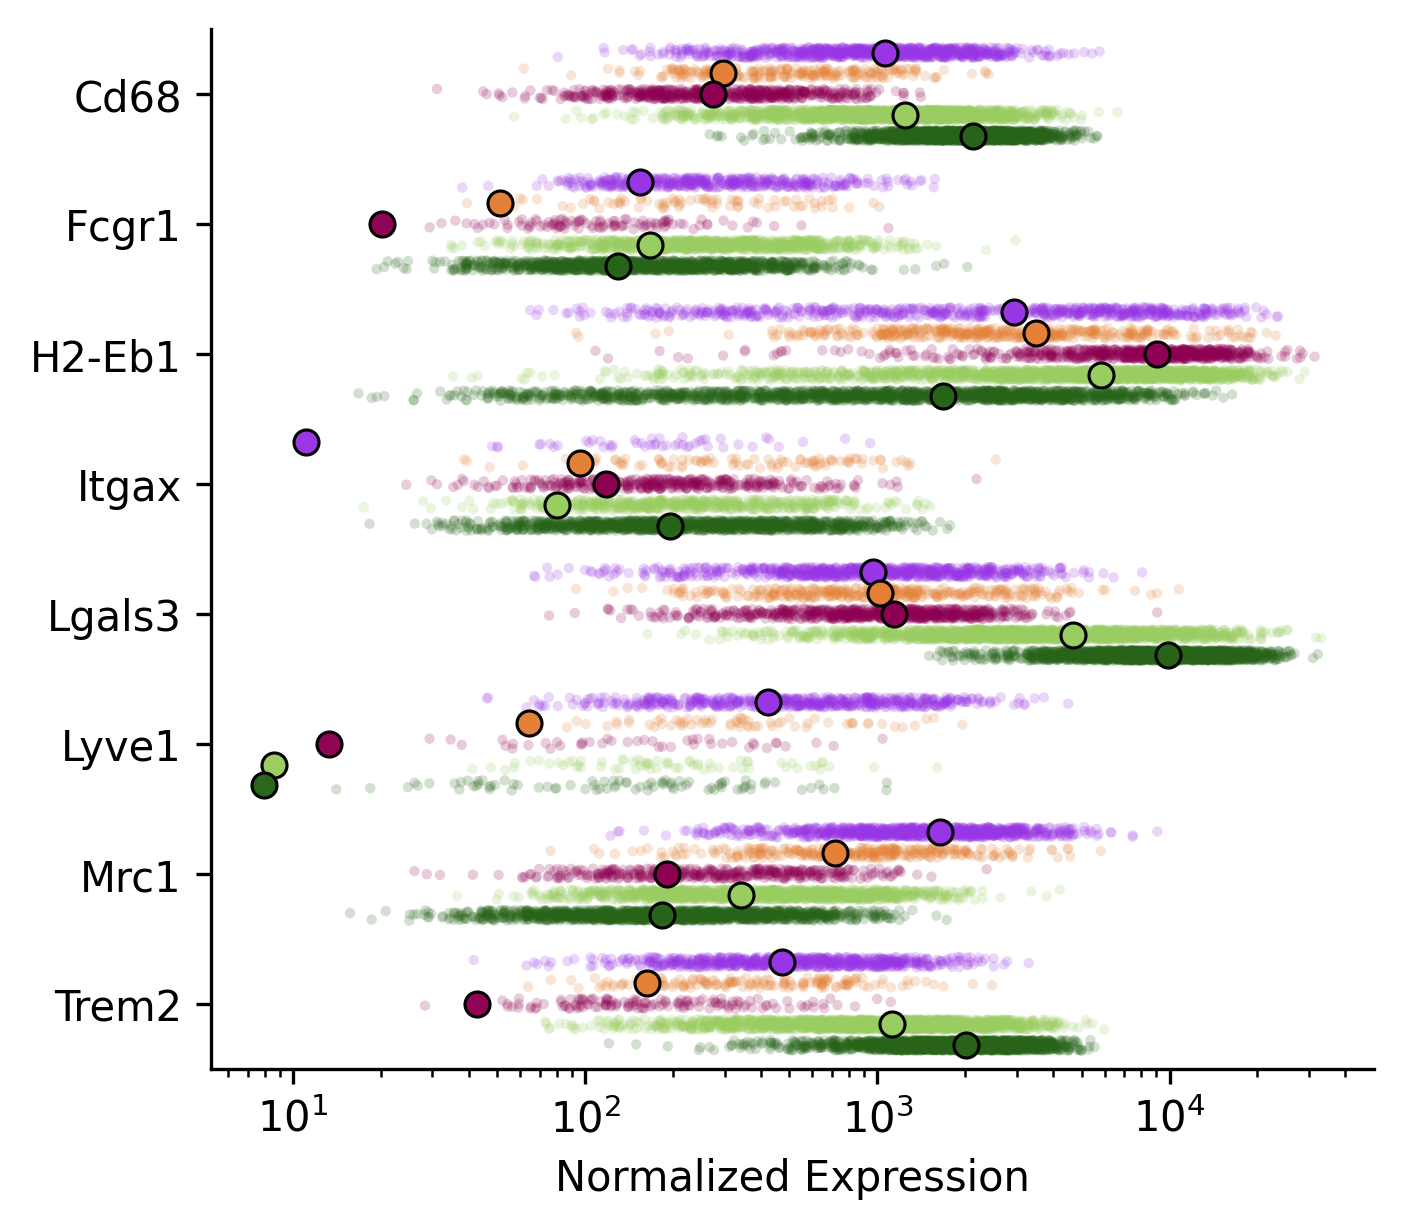

In [13]:
plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 4, 3.5
plt.rcParams['figure.figsize'] = 5, 4.5

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

tdf = res.copy()
tdf['keyName'] = tdf['key'].map(keyMap)
tdf['geneName'] = tdf['gene'].apply(lambda x: x.lower().capitalize())

fig, ax = plt.subplots()

sorter = [
    'Cd68',
    'Fcgr1',
    'Mrc1',
    'Lyve1',
    'Itgax',    
    'H2-eb1',
    'Lgals3',
    'Trem2',
    # 'Gpnmb',
]


# plot the means
mu = tdf.groupby(['cellType', 'geneName'])['cpm'].mean().reset_index()
# mu = mu.sort_values(by='geneName')

mu['geneName'] = mu['geneName'].astype("category")
mu['geneName'] = mu['geneName'].cat.set_categories(sorter)
mu['geneName'] = np.where(mu['geneName'] == 'H2-eb1', 'H2-Eb1', mu['geneName'])
tdf['geneName'] = np.where(tdf['geneName'] == 'H2-eb1', 'H2-Eb1', tdf['geneName'])

sns.stripplot(data=mu, 
              y='geneName',
              x='cpm',
              hue='cellType',
              dodge=True,
              s=6,
              # marker="|",
              linewidth=0.75,
              edgecolor='k',
              palette=ut.MACCOLORS,
              # palette=['k', 'k', 'k', 'k', 'k'],
              legend=False,
              alpha=0.99,
              zorder=2,
              ax=ax,
             )

sns.stripplot(data=tdf, 
              y='geneName',
              x='cpm',
              hue='cellType',
              palette=ut.MACCOLORS,
              legend=False,
              jitter=0.2,
              s=2.5,
              alpha=0.2,
              zorder=1,
              dodge=True,
              ax=ax)

# ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("Normalized Expression")
ax.set_ylabel("")
ax.set_facecolor('None')

sns.despine()
plt.show()

In [7]:
outdir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/FIGURE_DATA/FIG2/"
name = "geneExp.csv"
tdf.to_csv(f"{outdir}{name}", index=False,)
print('done')

done


In [8]:
sortOrder = [
    'Cd68',
    'Fcgr1',
    'Mrc1',
    'Lyve1',
    'Itgax',    
    'H2-eb1',
    'Lgals3',
    'Trem2'
    'Gpnmb',
]

In [9]:
mu.head()

,cellType,geneName,cpm
0,Mac1,Cd68,1065.725175
1,Mac1,Fcgr1,153.996962
2,Mac1,H2-eb1,2933.272843
3,Mac1,Itgax,11.123626
4,Mac1,Lgals3,970.254104


In [10]:
# t = tdf[tdf['gene'] == 'MRC1']

# sns.histplot(t, 
#              x='cpm')